# SEMI SUPERVISED LEARNING WITH DECISION TREE

In [1]:
import os
from PIL import Image, ImageFilter
import numpy as np 

#Dataset Directory 
alphabet_dir = "ASL_Dataset/Train"

images = []
labels = []

max_images_per_folder = 1000
size = (256, 256)

Pre processing the dataset

In [2]:
def load_images_generator(folder_path, max_images_per_folder, size):
    image_counter = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            if image_counter >= max_images_per_folder:
                break
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.resize(size)
            image = image.convert('L')
            image = np.array(image) / 255.0
            image = remove_noise(image)
            yield image
            image_counter += 1

def remove_noise(image):
    pil_image = Image.fromarray(np.uint8(image*255))  
    denoised_image = pil_image.filter(ImageFilter.GaussianBlur(radius=2))
    denoised_array = np.array(denoised_image) / 255.0  
    return denoised_array

def load_images():
    images = []
    labels = []

    for folder_name in os.listdir(alphabet_dir):
        folder_path = os.path.join(alphabet_dir, folder_name)
        folder_images = load_images_generator(folder_path, max_images_per_folder, size)
        images.extend(folder_images)
        labels.extend([folder_name] * max_images_per_folder)

    return np.array(images), np.array(labels)

In [3]:
images, labels = load_images()
len(labels)

28000

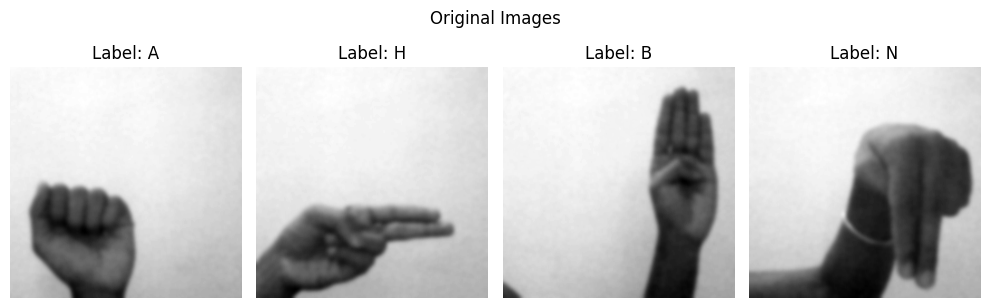

In [4]:
import matplotlib.pyplot as plt

random_indices = np.random.choice(len(labels), size=4, replace=False)

Original_images = images[random_indices]
Original_labels = labels[random_indices]

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(Original_images[i], cmap='gray')
    plt.title(f"Label: {Original_labels[i]}")
    plt.axis('off')
plt.suptitle('Original Images')
plt.tight_layout()
plt.show()

PCA


In [5]:
num_images = images.shape[0]
flattened_images = images.reshape(num_images, -1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
standardized_images = scaler.fit_transform(flattened_images)

from sklearn.decomposition import PCA

num_components = 25
pca = PCA(n_components=num_components)
reduced_images = pca.fit_transform(standardized_images)
reconstructed_images = pca.inverse_transform(reduced_images)


In [6]:
print(reconstructed_images.shape)
print(reduced_images.shape)

(28000, 65536)
(28000, 25)


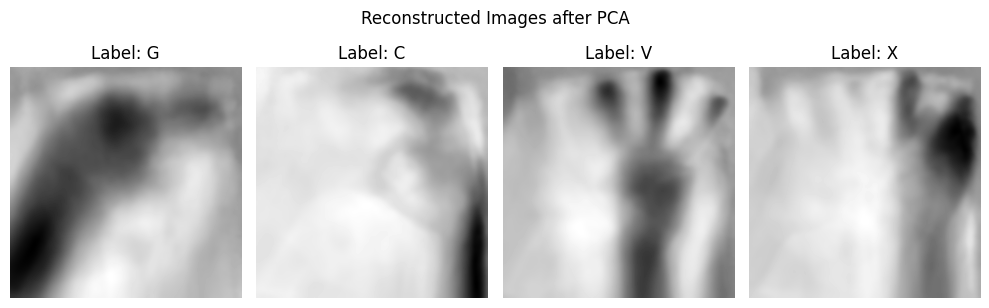

In [7]:
import numpy as np 

reconstructed_img = reconstructed_images[random_indices]
reconstructed_labels = labels[random_indices]

plt.figure(figsize=(10, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(reconstructed_img[i].reshape(size), cmap='gray')
    plt.title(f"Label: {reconstructed_labels[i]}")
    plt.axis('off')
plt.suptitle('Reconstructed Images after PCA')
plt.tight_layout()
plt.show()

Outlier Detection Plot


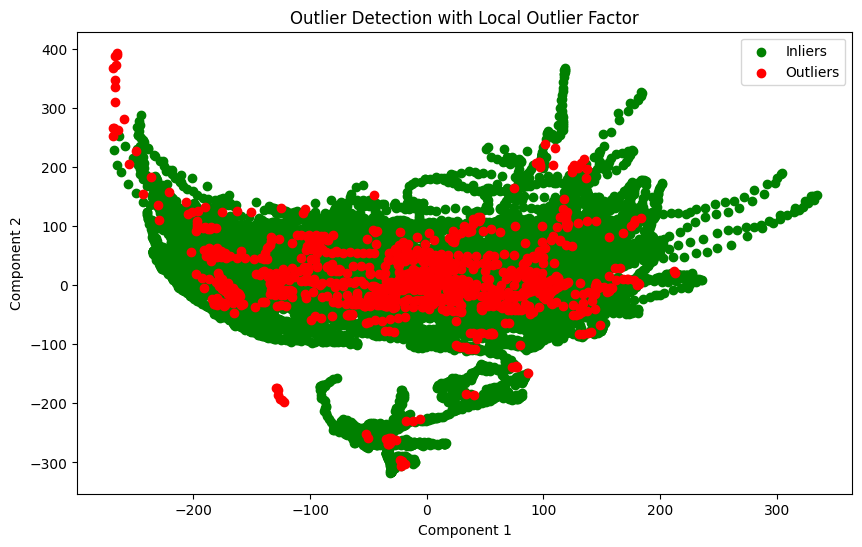

In [8]:
from sklearn.neighbors import LocalOutlierFactor
outlier_detector = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
outlier_labels = outlier_detector.fit_predict(reduced_images)

outliers = reduced_images[outlier_labels == -1]
inliers = reduced_images[outlier_labels == 1]

plt.figure(figsize=(10, 6))
plt.scatter(inliers[:, 0], inliers[:, 1], c='green', label='Inliers')
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', label='Outliers')
plt.title('Outlier Detection with Local Outlier Factor')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

In [9]:
import cupy as cp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [10]:

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, stratify=y)

X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_train, y_train, test_size=0.8)

X_labeled = X_labeled.reshape(X_labeled.shape[0], -1)
X_unlabeled = X_unlabeled.reshape(X_unlabeled.shape[0], -1)

In [11]:
X_labeled_cp = cp.array(X_labeled)
X_unlabeled_cp = cp.array(X_unlabeled)
y_labeled_cp = cp.array(y_labeled)
y_unlabeled_cp = cp.array(y_unlabeled)

print(f"Data before starting the iterations\n Labeled Data Size - {X_labeled_cp.shape[0]}, Unlabeled Data Size - {X_unlabeled_cp.shape[0]}\n")

Data before starting the iterations
 Labeled Data Size - 4480, Unlabeled Data Size - 17920



Decision Tree Classifier

Iteration 0: Labeled Data Size - 4480, Unlabeled Data Size - 17920
Iteration 1: Labeled Data Size - 6272, Unlabeled Data Size - 16128


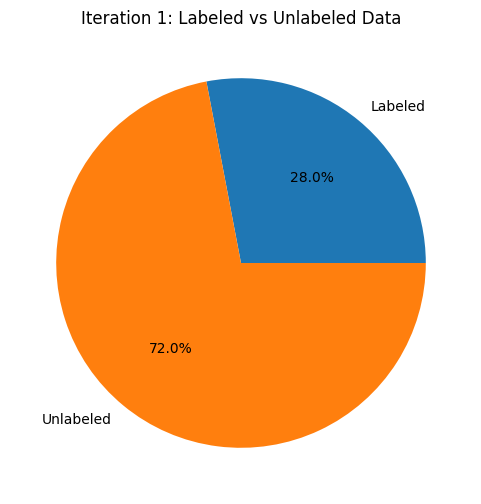

Iteration 2: Labeled Data Size - 7885, Unlabeled Data Size - 14515


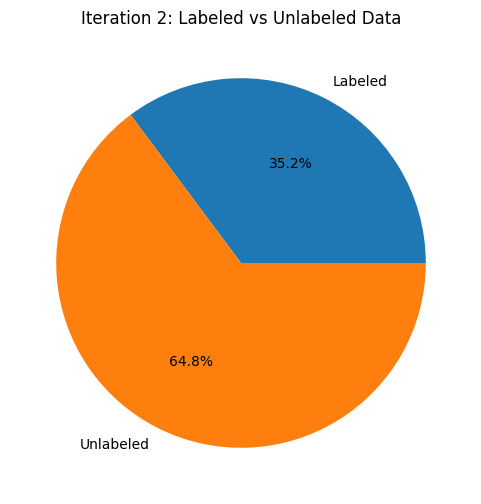

Iteration 3: Labeled Data Size - 9336, Unlabeled Data Size - 13064


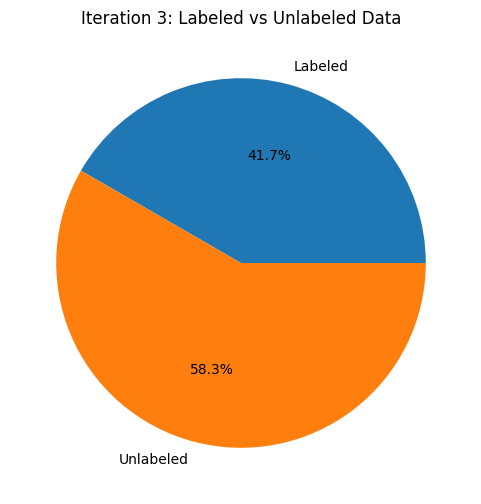

Iteration 4: Labeled Data Size - 10643, Unlabeled Data Size - 11757


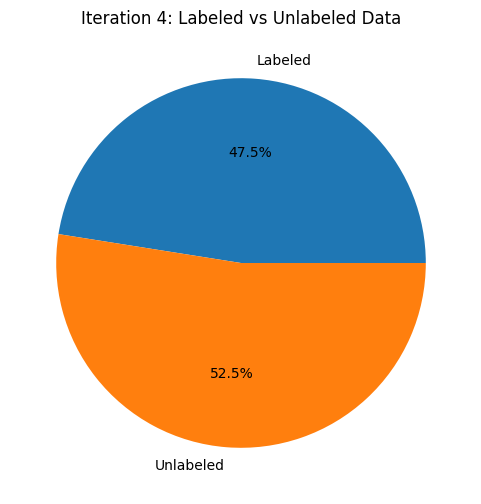

Iteration 5: Labeled Data Size - 11818, Unlabeled Data Size - 10582


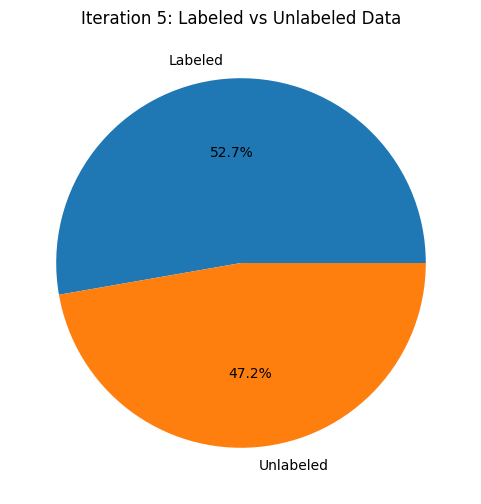

Iteration 6: Labeled Data Size - 12876, Unlabeled Data Size - 9524


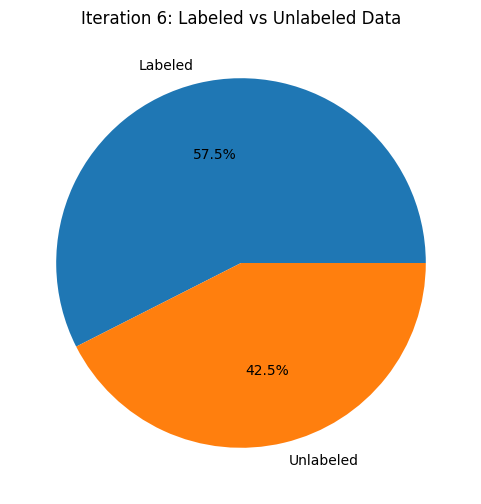

Iteration 7: Labeled Data Size - 13828, Unlabeled Data Size - 8572


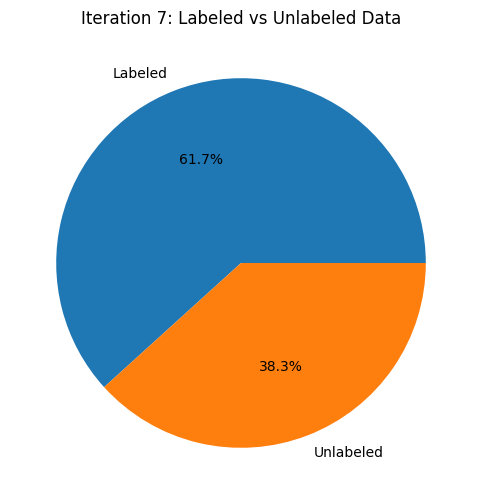

Iteration 8: Labeled Data Size - 14686, Unlabeled Data Size - 7714


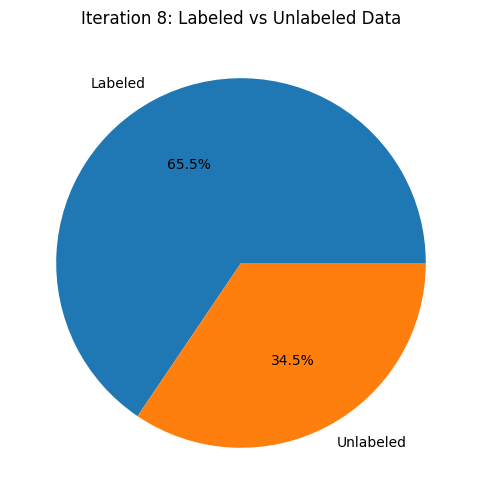

Accuracy: 0.85294117647058826


In [12]:
classifier = DecisionTreeClassifier(max_depth=8, criterion='entropy', random_state=2411)
confidence_threshold = 0.9
num_iterations = 8

print(f"Iteration 0: Labeled Data Size - {X_labeled.shape[0]}, Unlabeled Data Size - {X_unlabeled.shape[0]}")
    # Select high-confidence predictions
for i in range(num_iterations):
    classifier.fit(X_labeled, y_labeled)
    y_pred = classifier.predict(X_unlabeled)

    # Select high-confidence predictions
    y_pred_prob = classifier.predict_proba(X_unlabeled)
    max_probs = np.max(y_pred_prob, axis=1)
    high_confidence_indices = np.argsort(max_probs)[-int(0.1 * len(X_unlabeled)):]
    pseudo_labels = y_pred[high_confidence_indices]

    # Add high-confidence examples to the labeled data
    X_labeled = np.concatenate([X_labeled, X_unlabeled[high_confidence_indices]])
    y_labeled = np.concatenate([y_labeled, pseudo_labels])

    # Remove high-confidence examples from the unlabeled data
    X_unlabeled = np.delete(X_unlabeled, high_confidence_indices, axis=0)
    y_unlabeled = np.delete(y_unlabeled, high_confidence_indices, axis=0)
    print(f"Iteration {i + 1}: Labeled Data Size - {X_labeled.shape[0]}, Unlabeled Data Size - {X_unlabeled.shape[0]}")
    # Plot pie charts
    labels = ['Labeled', 'Unlabeled']
    sizes = [X_labeled.shape[0], X_unlabeled.shape[0]]
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title(f'Iteration {i + 1}: Labeled vs Unlabeled Data')
    plt.show()

# After the iterations
y_pred = classifier.predict(X_unlabeled)
accuracy = accuracy_score(y_unlabeled, y_pred)
print("Accuracy:", accuracy)




Precision, Recall and F1-score

In [13]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_score, _ = precision_recall_fscore_support(cp.asnumpy(y_unlabeled_cp), cp.asnumpy(y_pred_cp), average='weighted')
print("Precision: {:.2f}".format(round(precision, 2)))
print("Recall: {:.2f}".format(round(recall, 2)))
print("F1-score: {:.2f}".format(round(f1_score, 2)))

Precision: 0.84
Recall: 0.82
F1-score: 0.82


In [14]:
from sklearn.metrics import classification_report

report = classification_report(cp.asnumpy(y_unlabeled_cp), cp.asnumpy(y_pred_cp))
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        800
           1       0.62      0.80      0.70        800
           2       0.86      0.69      0.76        800
           3       0.94      0.92      0.93        800
           4       0.85      0.77      0.80        800
           5       0.80      0.76      0.77        800
           6       0.81      0.75      0.78        800
           7       0.85      0.88      0.87        800
           8       0.80      0.81      0.80        800
           9       0.80      0.89      0.84        800
          10       0.88      0.82      0.85        800
          11       0.75      0.92      0.83        800
          12       0.87      0.82      0.85        800
          13       0.80      0.86      0.83        800
          14       0.98      0.95      0.96        800
          15       0.75      0.84      0.80        800
          16       0.86      0.84      0.8

Confusion Matrix

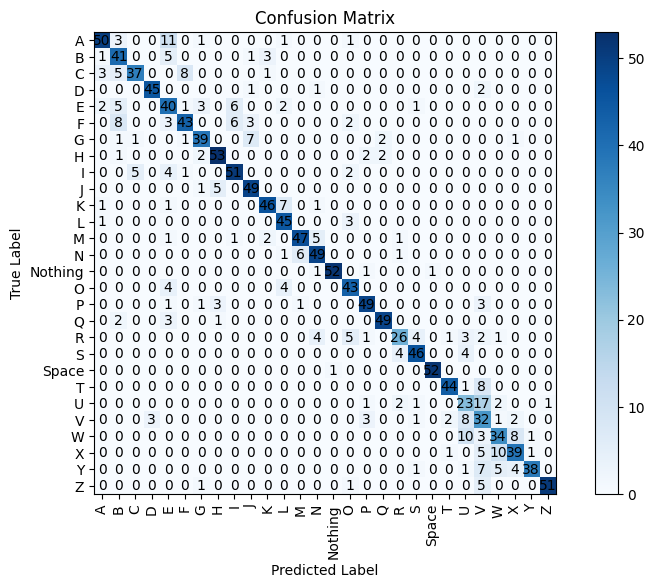

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(cp.asnumpy(y_unlabeled_cp), cp.asnumpy(y_pred_cp))
plt.figure(figsize=(10, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(label_encoder.classes_))
plt.xticks(tick_marks, label_encoder.classes_, rotation=90)
plt.yticks(tick_marks, label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(len(label_encoder.classes_)):
    for j in range(len(label_encoder.classes_)):
        plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center')
        
plt.show()

Hyperparameter Tuning 

In [16]:
import cupy as cp
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Convert the data back to NumPy arrays
X_labeled = cp.asnumpy(X_labeled)
y_labeled = cp.asnumpy(y_labeled)

# Define the hyperparameters to search over
param_grid = {
    'max_depth':list(range(1, 32)),
    'criterion': ['gini', 'entropy'],
}

# Create the classifier
classifier = DecisionTreeClassifier(random_state=2411)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=8)
grid_search.fit(X_labeled, y_labeled)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 12}


T-SNE plot

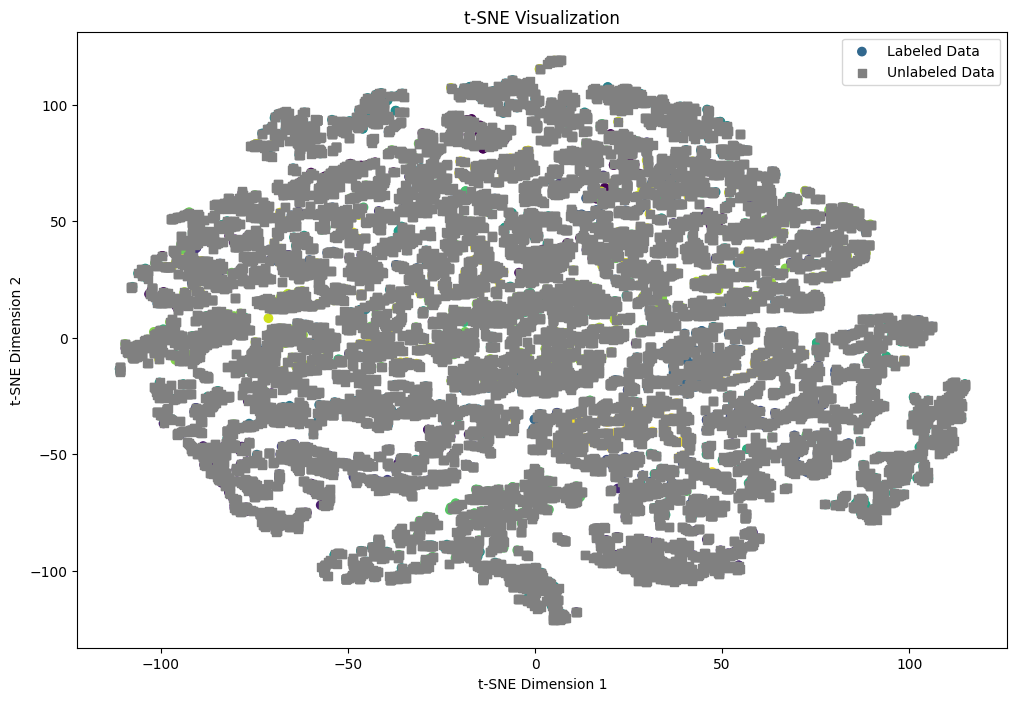

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=2411, perplexity=30, n_iter=1000)
X_combined = np.concatenate((X_labeled, X_unlabeled), axis=0)
X_tsne = tsne.fit_transform(X_combined)

# Separate labeled and unlabeled data in t-SNE space
X_tsne_labeled = X_tsne[:X_labeled.shape[0]]
X_tsne_unlabeled = X_tsne[X_labeled.shape[0]:]

# Plot the t-SNE visualization
plt.figure(figsize=(12, 8))
plt.scatter(X_tsne_labeled[:, 0], X_tsne_labeled[:, 1], c=y_labeled, cmap='viridis', label='Labeled Data')
plt.scatter(X_tsne_unlabeled[:, 0], X_tsne_unlabeled[:, 1], c='gray', label='Unlabeled Data', marker='s')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.legend()
plt.show()

